In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, ConstantKernel as C
from sklearn.model_selection import RandomizedSearchCV
from scipy.optimize import minimize
from scipy.stats.qmc import LatinHypercube
from scipy.stats import uniform, loguniform, norm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import GPy

# Guide and Ideas for Capstone Project - Function 3 (3D)

# Function 3: Drug Discovery Problem
In this example, you are doing drug discovery! You can select three compounds to create a drug, and receive a measurement of the people’s adverse reaction to the drug. You want to make this as close as possible to zero. (hint: one of the variables may not cause any effects on the person).

We begin this guide by downloading the data:

In [2]:
X = np.load('initial_data/function_3/initial_inputs.npy')
Y = np.load('initial_data/function_3/initial_outputs.npy')

In [3]:
def format_query(point, NoOfDigits):
    return '-'.join(f"{x:.{NoOfDigits}f}" for x in point)

In [4]:
# Print X with 16 digits of precision
for row in X:
    print(format_query(row,16))

# Print a separator line
print("-" * 50)

# Print Y with 16 digits of precision
print(format_query(Y,16))

0.1715252068810621-0.3439168702758373-0.2487372010692387
0.2421144606124933-0.6440742697791076-0.2724328091994552
0.5349057202251034-0.3985009153676317-0.1733887289456773
0.4925814146371343-0.6115931882759961-0.3401763860035727
0.1346216663206111-0.2199172404897456-0.4582062196492270
0.3455232705197697-0.9413598305723256-0.2693634790694064
0.1518366323741680-0.4399906189664438-0.9908818665589511
0.6455028351793182-0.3971429395797703-0.9197713377032198
0.7469119451655177-0.2841963092257342-0.2262998548875255
0.1704769939696806-0.6970324006861340-0.1491694337083003
0.2205493370831766-0.2978252442230862-0.3435553444167259
0.6660136587669346-0.6719851513369297-0.2462952966705313
0.0468089497224974-0.2313602407834674-0.7706175921643000
0.6000972824185008-0.7251357252228826-0.0660886414953487
0.9659948489488087-0.8611196897300882-0.5668291312870885
--------------------------------------------------
-0.1121222004625690--0.0879628602273645--0.1114146542953240--0.0348353133500786--0.04800758439

In [5]:
# load w1 data
pd_w1 = pd.read_csv("data/capstone_results_w1.csv")
print(pd_w1.head())

   Week  Student  Fn        X1        X2        X3        X4  X5  X6  X7  X8  \
0     1      428   1  0.628540  0.628540       NaN       NaN NaN NaN NaN NaN   
1     1      428   2  0.983984  0.999998       NaN       NaN NaN NaN NaN NaN   
2     1      428   3  0.432432  0.256757  0.500001       NaN NaN NaN NaN NaN   
3     1      428   4  0.421053  0.368421  0.368421  0.421053 NaN NaN NaN NaN   
4     1      428   5  0.310345  0.827586  0.965517  0.931034 NaN NaN NaN NaN   

             Y  
0     2.000000  
1    -0.143941  
2    -0.053196  
3     0.692067  
4  1863.356016  


In [6]:
pw_w1_fn1 = pd_w1[pd_w1['Fn']==3]
# Extract X1 and X2 into a 2D array and Y into a 1D array
# Here we're ensuring to drop any NaN values as they can't be used in most models.
X_w1_new_points = pw_w1_fn1[['X1','X2','X3']].dropna().values
Y_w1_new_points = pw_w1_fn1['Y'].dropna().values
print(X_w1_new_points)
print(Y_w1_new_points)

[[0.432432 0.256757 0.500001]
 [0.99     0.99     0.808081]
 [0.9981   0.001449 0.998173]
 [0.40404  0.262626 0.      ]
 [0.466666 0.111111 0.533333]]
[-0.05319638 -0.08980565 -0.49293157 -0.13594905 -0.06478802]


In [7]:
#append w1 data to the end

X_w1 = np.vstack((X, X_w1_new_points))
Y_w1 = np.append(Y, Y_w1_new_points)
print(X_w1)
print(Y_w1)

[[0.17152521 0.34391687 0.2487372 ]
 [0.24211446 0.64407427 0.27243281]
 [0.53490572 0.39850092 0.17338873]
 [0.49258141 0.61159319 0.34017639]
 [0.13462167 0.21991724 0.45820622]
 [0.34552327 0.94135983 0.26936348]
 [0.15183663 0.43999062 0.99088187]
 [0.64550284 0.39714294 0.91977134]
 [0.74691195 0.28419631 0.22629985]
 [0.17047699 0.6970324  0.14916943]
 [0.22054934 0.29782524 0.34355534]
 [0.66601366 0.67198515 0.2462953 ]
 [0.04680895 0.23136024 0.77061759]
 [0.60009728 0.72513573 0.06608864]
 [0.96599485 0.86111969 0.56682913]
 [0.432432   0.256757   0.500001  ]
 [0.99       0.99       0.808081  ]
 [0.9981     0.001449   0.998173  ]
 [0.40404    0.262626   0.        ]
 [0.466666   0.111111   0.533333  ]]
[-0.1121222  -0.08796286 -0.11141465 -0.03483531 -0.04800758 -0.11062091
 -0.39892551 -0.11386851 -0.13146061 -0.09418956 -0.04694741 -0.10596504
 -0.11804826 -0.03637783 -0.05675837 -0.05319638 -0.08980565 -0.49293157
 -0.13594905 -0.06478802]


## Random Search

The simplest solution would be a simple random search, that is, we can randomly choose our next query point:

In [8]:
next_query = np.random.uniform(size = 3)
print(next_query)

[0.0365236  0.58916281 0.13564861]


While this solution is easy to implement, we know it will be very slow. However, it could serve as a placeholder for gathering more information while you research which method you want to use for each function.

## Visualizing our data and thinking of the problem

Initial Data Analysis: Start by analyzing the initial dataset to understand the relationships between the variables and the adverse reaction measurements. Look for patterns or correlations that might suggest which compounds are more influential.

what we know about the problem:

1.From the hints, one of the variables may not cause any effects on the person.(this could be compound 3)

2. From the hints, we want to make the adverse reaction as close as possible to zero!

3. The problem is three-dimensional.

4. The problem will have small length-scale (that is, we expect the modes to be very small)

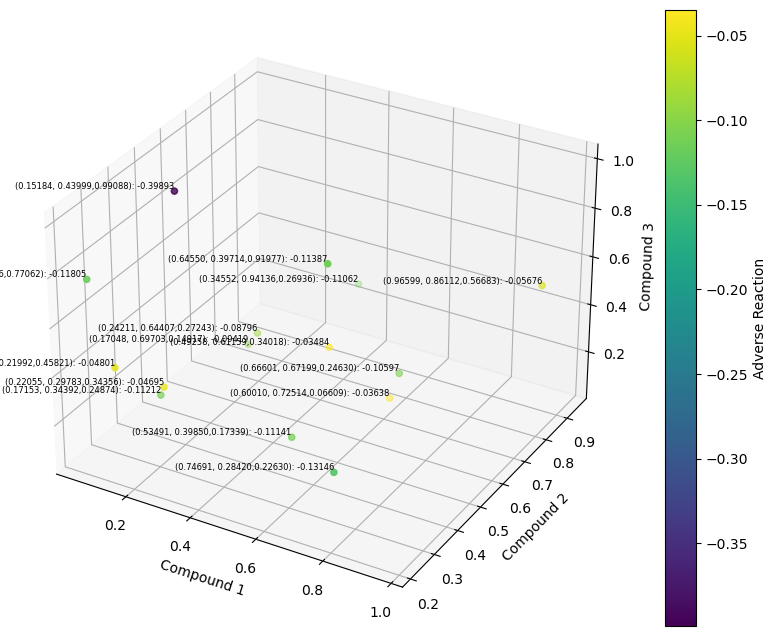

In [9]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap='viridis')

# Create colorbar
cbar = plt.colorbar(sc)
cbar.set_label('Adverse Reaction')

# Set labels for axes
ax.set_xlabel('Compound 1')
ax.set_ylabel('Compound 2')
ax.set_zlabel('Compound 3')

# Looping over the data points to add labels with 16 digits of precision
for i in range(len(X)):
    x_coord = f"{X_w1[i, 0]:.5f}"
    y_coord = f"{X_w1[i, 1]:.5f}"
    z_coord = f"{X_w1[i, 2]:.5f}"
    y_value = f"{Y_w1[i]:.5f}"
    label = f"({x_coord}, {y_coord},{z_coord}): {y_value}"
    ax.text(X_w1[i, 0], X_w1[i, 1], X_w1[i, 2], label, fontsize=6, ha='right', va='bottom')


# Show plot
plt.show()

# Convert to DataFrame for easier handling


In [10]:
df = pd.DataFrame(X_w1, columns=['x1', 'x2', 'x3'])
df['output'] = Y_w1

In [11]:
# Statistical Summary
print("Statistical Summary:")
print(df.describe())

Statistical Summary:
              x1         x2         x3     output
count  20.000000  20.000000  20.000000  20.000000
mean    0.471335   0.469355   0.444070  -0.122209
std     0.296456   0.281072   0.308110   0.116191
min     0.046809   0.001449   0.000000  -0.492932
25%     0.208293   0.261159   0.241296  -0.114913
50%     0.449549   0.397822   0.341866  -0.100077
75%     0.650631   0.678247   0.617776  -0.055868
max     0.998100   0.990000   0.998173  -0.034835


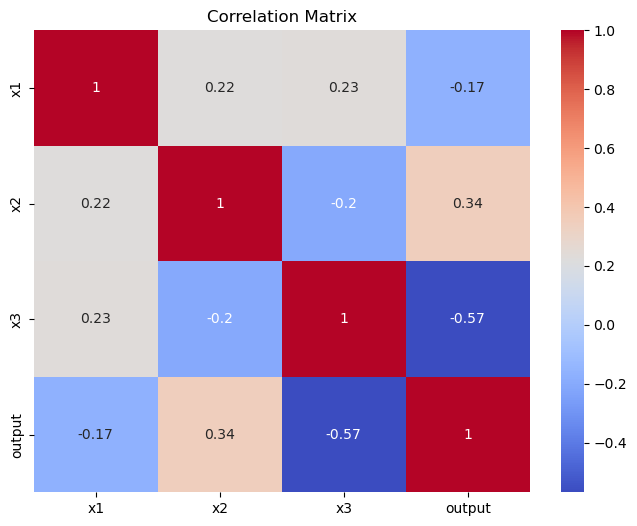

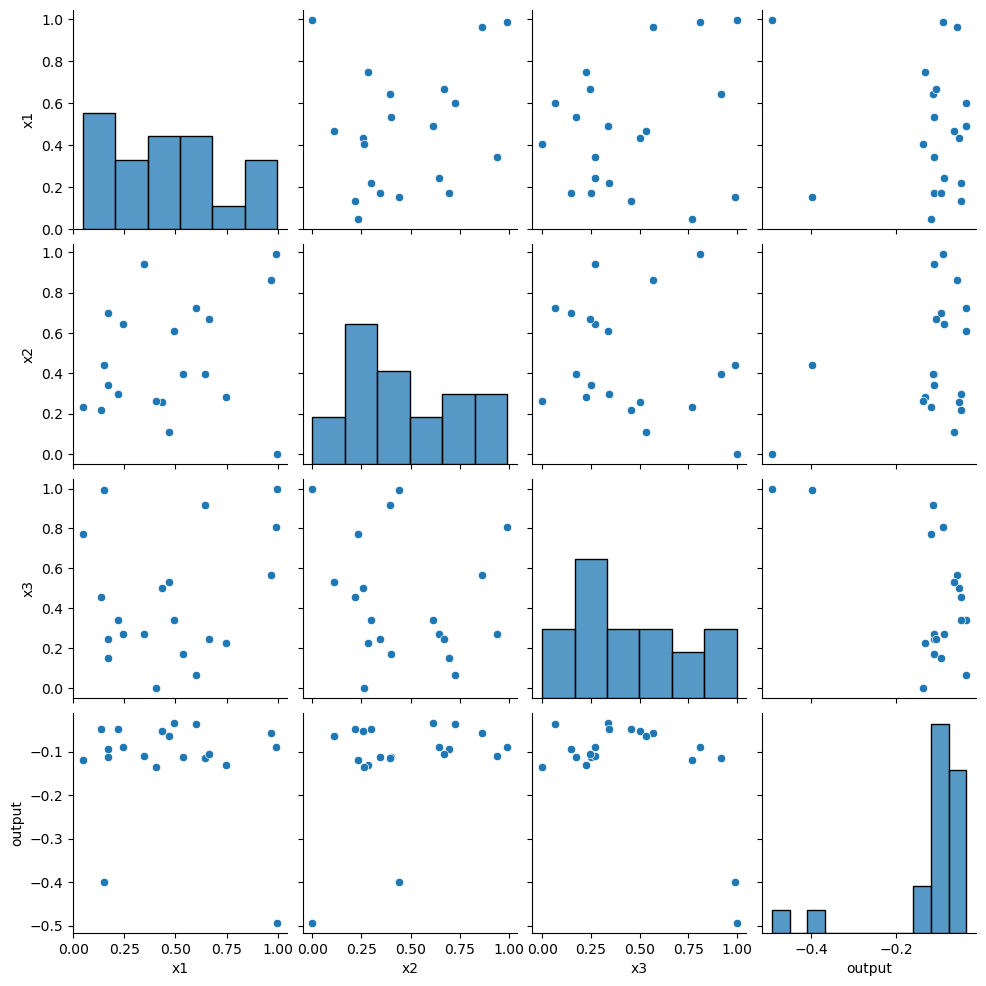

In [12]:
# Calculate correlations
correlations = df.corr()

# Plotting the correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Pairplot to visualize relationships
sns.pairplot(df)
plt.show()

In [17]:
#Appoach 1

# Random search around an area restricted around
# best points so far
# 0.1518366323741680	0.4399906189664430	0.9908818665589510	-0.3989255131463010
# 0.9981	0.001449	0.998173	-0.492931566
# 0.40404	0.262626	0	-0.135949048

delta = 0.05

# Given the best points are around 0.65, we want to center our search around this value
# and expand slightly beyond it to continue exploring.
domain_start_x1 = 0.1 - delta  # Now starts slightly below the best points
domain_end_x1 = 0.99 + delta    # Now ends slightly above the best points
domain_start_x2 = 0.0001 - delta  
domain_end_x2 = 0.44 + delta   
domain_start_x3 = 0 - delta  
domain_end_x3 = 0.998 + delta   
print(f"domain_start_x1= {domain_start_x1} and domain_end_x1 = {domain_end_x1}")

next_query_x1 = np.random.normal(domain_start_x1, scale = 0.01)
next_query_x2 = np.random.normal(domain_start_x2, scale = 0.01)
next_query_x3 = np.random.normal(domain_start_x3, scale = 0.01)
print('Next query Random: ', [next_query_x1, next_query_x2,next_query_x3])

domain_start_x1= 0.05 and domain_end_x1 = 1.04
Next query Random:  [0.03934855107170893, -0.054027174719176986, -0.04594432911019673]


In [18]:
def compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi):
    """
    Compute kappa and xi values for each week in an optimization loop.

    Parameters:
    N_WEEKS: Number of weeks for the optimization loop.
    kappa_initial: Initial value of kappa.
    kappa_decay: Decay rate of kappa per week.
    min_kappa: Minimum value of kappa.
    xi_initial: Initial value of xi.
    xi_decay: Decay rate of xi per week.
    min_xi: Minimum value of xi.

    Returns:
    kappa_array: Array of kappa values for each week.
    xi_array: Array of xi values for each week.
    """

    kappa_array = np.zeros(N_WEEKS)
    xi_array = np.zeros(N_WEEKS)

    for week in range(N_WEEKS):
        kappa = max(kappa_initial * (kappa_decay ** week), min_kappa)
        xi = max(xi_initial * (xi_decay ** week), min_xi)
        kappa_array[week] = kappa
        xi_array[week] = xi

    return kappa_array, xi_array

# Example usage:
N_WEEKS = 10
kappa_initial = 1.96
kappa_decay = 0.9
min_kappa = 0.1
xi_initial = 0.1
xi_decay = 0.9
min_xi = 0.01

kappa_array, xi_array = compute_kappa_xi_arrays(N_WEEKS, kappa_initial, kappa_decay, min_kappa, xi_initial, xi_decay, min_xi)
print("Kappa Array:", kappa_array)
print("Xi Array:", xi_array)

Kappa Array: [1.96       1.764      1.5876     1.42884    1.285956   1.1573604
 1.04162436 0.93746192 0.84371573 0.75934416]
Xi Array: [0.1        0.09       0.081      0.0729     0.06561    0.059049
 0.0531441  0.04782969 0.04304672 0.03874205]


In [19]:
#Approach 2 - modified
#Randomized Hyperparameter Search: 
#defines a search space for the kernel parameters, creates a Gaussian process model, and then uses RandomizedSearchCV to find the best hyperparameters based on cross-validation. 
# The best model and parameters are then displayed.
param_distributions = {
    'kernel__k1__constant_value': loguniform(1e-3, 1e3),
    'kernel__k2__length_scale': loguniform(1e-4, 1e2)
    #'k2__noise_level': loguniform(1e-3, 1e1)
}

kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))  

gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=20)

random_search = RandomizedSearchCV(gp, param_distributions, n_iter=10, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_w1,Y_w1)

best_gp = random_search.best_estimator_
best_params = random_search.best_params_
print("Best Parameters:", best_params)
print(f"Log-marginal-likelihood: {best_gp.log_marginal_likelihood(best_gp.kernel_.theta)}")

Best Parameters: {'kernel__k1__constant_value': 0.3905441275210792, 'kernel__k2__length_scale': 0.005589524205217923}
Log-marginal-likelihood: 15.154558961379948


In [20]:
#Evaluate Model Performance

def evaluate_model_performance(model, X_test, Y_test, model_type='sklearn'):
    """
    Evaluate the performance of a Gaussian Process model.

    Parameters:
    model: The trained Gaussian Process model.
    X_test: Test data features (numpy array).
    Y_test: True values for test data (numpy array).

    Returns:
    mse: Mean Squared Error of the model on the test data.
    r2: R-squared value indicating the proportion of variance explained by the model.
    """

    if model_type == 'gpy':
        y_pred, var_pred = model.predict(X_test)
        std_pred = np.sqrt(var_pred)
    elif model_type == 'sklearn':
        y_pred, std_pred = model.predict(X_test, return_std=True)

    # Ensure y_pred is 1D
    y_pred = y_pred.flatten()

    # Calculate residuals
    residuals = Y_test.flatten() - y_pred

    # Check if dimensions match
    if y_pred.shape != residuals.shape:
        raise ValueError(f"Shape mismatch: y_pred shape {y_pred.shape} and residuals shape {residuals.shape} must be the same.")        
        
    # Calculate MSE and R-squared
    mse = mean_squared_error(Y_test, y_pred)
    r2 = r2_score(Y_test, y_pred)
    
    print(f"MSE: {mse}")
    print(f"R-squared: {r2}")

    # Analyze residuals
    residuals = Y_test - y_pred

    # Plot residuals to look for patterns
    plt.scatter(y_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    plt.show()

    return mse, r2

# Usage example:
# mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points)
# print(f"MSE: {mse}")
# print(f"R-squared: {r2}")

In [21]:
# define multiple acquisition functions

#an acquisition function used in Bayesian optimization. 
# The EI is calculated for a set of points X, given a Gaussian process gp. It's used to determine the next point to sample.
def expected_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei


# Probability of Improvement acquisition function
def probability_of_improvement(X_grid, gp, xi=0.01, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
        mu_sample_opt = np.max(gp.predict(gp.X))
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)
        mu_sample_opt = np.max(gp.predict(gp.X_train_, return_std=False))

    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = imp / sigma
        pi = norm.cdf(Z)
        pi[sigma == 0.0] = 0.0

    return pi


# Define the UCB acquisition function
# After optimizing the hyperparameters, the Upper Confidence Bound (UCB) is used as the acquisition function in the weekly optimization loop. 
# The UCB balances exploration (trying new, uncertain points) and exploitation (focusing on points known to yield good results).
def upper_confidence_bound(X_grid, gp, kappa=1.96, model_type='gpy'):
    if model_type == 'gpy':
        mu, var = gp.predict(X_grid)
        sigma = np.sqrt(var)
    elif model_type == 'sklearn':
        mu, sigma = gp.predict(X_grid, return_std=True)

    return mu + kappa * sigma


In [22]:
# define grid based on dimensions

def generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points):
    """
    Generate a 2D grid of points for optimization.

    Parameters:
    domain_start_x1: Starting value of the first dimension.
    domain_end_x1: Ending value of the first dimension.
    domain_start_x2: Starting value of the second dimension.
    domain_end_x2: Ending value of the second dimension.
    num_points: Number of points to generate in each dimension.

    Returns:
    X_grid: A 2D numpy array of grid points.
    """

    # Generate arrays of evenly spaced values in each dimension
    x1 = np.linspace(domain_start_x1, domain_end_x1, num_points)
    x2 = np.linspace(domain_start_x2, domain_end_x2, num_points)

    # Use numpy's meshgrid function to create a grid efficiently
    X_grid = np.array(np.meshgrid(x1, x2)).T.reshape(-1, 2)

    return X_grid
# Example usage:
# domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2 = 0.6, 0.65, 0.6, 0.65
# num_points = 100
# X_grid = generate_2d_grid(domain_start_x1, domain_end_x1, domain_start_x2, domain_end_x2, num_points)

def generate_nd_grid(max_points, dimensions):
    # define range for input
	r_min, r_max = 0, 1.0

	# generate a random sample from the domain (dimensions)
	nd_grid = r_min + np.random.rand(max_points, dimensions) * (r_max - r_min)
	
	return np.array(nd_grid)


In [23]:
# propose the next points for all three acquisition functions

def propose_next_point(xi, kappa, X_grid, best_gp, model_type = 'sklearn'):
    """
    Update exploration-exploitation parameters and calculating next query points.
   
    Returns:
    Next query points for EI, PI, and UCB.
    """


    # EI next point calculation
    ei_values = expected_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_ei = np.argmax(ei_values)
    next_point_ei = X_grid[next_point_index_ei]
    print('Next query EI: ', format_query(next_point_ei, 6))

    # PI next point calculation
    pi_values = probability_of_improvement(X_grid, best_gp, xi,model_type)
    next_point_index_pi = np.argmax(pi_values)
    next_point_pi = X_grid[next_point_index_pi]
    print('Next query PI: ', format_query(next_point_pi, 6))

    # UCB next point calculation
    ucb_value = upper_confidence_bound(X_grid, best_gp, kappa,model_type)
    next_point_index_ucb = np.argmax(ucb_value)
    next_point_ucb = X_grid[next_point_index_ucb]
    print('Next query UCB: ', format_query(next_point_ucb, 6))

    return next_point_ei, next_point_pi, next_point_ucb

Next query EI:  0.059181-0.043989-0.161875
Next query PI:  0.430995-0.871170-0.000061
Next query UCB:  0.996386-0.002748-0.006454
MSE: 2.6735821061413258e-18
R-squared: 0.9999999999999999


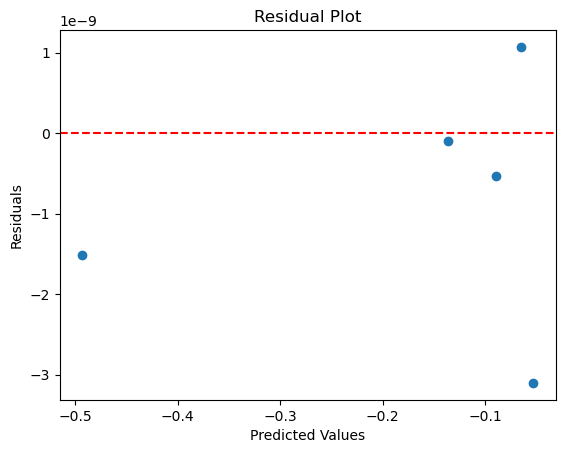

In [24]:
#Approach 2: using sklearn GP model

# generate grid
max_points = 7000000 #9,000,000 (too big for memory)
dimensions = 3  # Change this to the desired number of dimensions
X_grid = []
X_grid = generate_nd_grid(max_points, dimensions)


# Select updated kappa & xi based on the nth week
# Example for a specific week (e.g., week 1)
week_index = 1  # For week 2, as indexing starts from 0
xi_value = xi_array[week_index]
kappa_value = kappa_array[week_index]


# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid,best_gp,'sklearn')

mse, r2 = evaluate_model_performance(best_gp, X_w1_new_points, Y_w1_new_points,'sklearn')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")

##Aproach 3:  a Sparse Gaussian Process model

In [25]:
# Approach 3: gpy GP model

# Assuming X_w1 and Y_w1 are your data points
# Ensure X_w1 and Y_w1 are correctly shaped
# X_w1 = ... (your data, should be 2D, e.g., [n_samples, n_features])
# Y_w1 = ... (your data, should be 2D, e.g., [n_samples, 1])

# If Y_w1 is 1D, convert it to 2D
if Y_w1.ndim == 1:
    Y_w1_2d = Y_w1[:, np.newaxis]

# Create a kernel with RBF
kernel = GPy.kern.RBF(input_dim=X_w1.shape[1], variance=1., lengthscale=1.)

# Number of inducing points - this can be tuned based on your problem
num_inducing = 10  # This is an example value

# Creating a Sparse Gaussian Process Model
gp_sparse = GPy.models.SparseGPRegression(X_w1, Y_w1_2d, kernel, num_inducing=num_inducing)

# Model Optimization
gp_sparse.optimize(messages=True, optimizer='lbfgsb', max_iters=1000)

# Optionally, you can constrain parameters to be positive
gp_sparse.constrain_positive()

# After optimization, you can check the optimized hyperparameters
print("Optimized kernel parameters:", gp_sparse.kern)
print("Optimized noise variance:", gp_sparse.Gaussian_noise.variance)

# Evaluate model performance on a validation set, X_val and Y_val
Y_pred, Y_var = gp_sparse.predict(X_w1_new_points)
mse = np.mean((Y_w1_new_points - Y_pred)**2)
print("MSE on validation set:", mse)

reconstraining parameters sparse_gp


Optimized kernel parameters:   rbf.         |                value  |  constraints  |  priors
  variance     |  0.08564575602426584  |      +ve      |        
  lengthscale  |   0.7304508083930615  |      +ve      |        
Optimized noise variance:   index  |  sparse_gp.Gaussian_noise.variance  |  constraints  |  priors
  [0]    |                         0.00279773  |      +ve      |        
MSE on validation set: 0.047861692994518555


Next query EI:  0.994061-0.998215-0.005415
Next query PI:  0.000069-0.001203-0.300755
Next query UCB:  0.994061-0.998215-0.005415
MSE: 0.0006374437556669144
R-squared: 0.9766593902959292


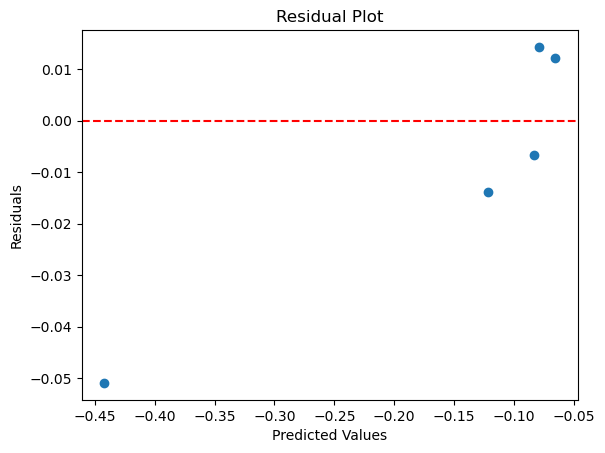

In [26]:
# EI, PI, UCB next point calcuation
next_point_ei, next_point_pi, next_point_ucb = propose_next_point(xi_value,kappa_value,X_grid, gp_sparse,'gpy')

mse, r2 = evaluate_model_performance(gp_sparse, X_w1_new_points, Y_w1_new_points,'gpy')
#print(f"MSE: {mse}")
#print(f"R-squared: {r2}")